This is the first try on implementing a LSTM on this project.

In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from comparation import comparation

# Semilla fija para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


In [442]:

# Cargar archivo unificado
df = pd.read_csv("oferta_academica_unificada.csv")

# Eliminar filas sin datos clave
df = df.dropna(subset=['Materia', 'Total_Cupos', 'semestre_numerico'])

# Codificar materia
le = LabelEncoder()
df['materia_codificada'] = le.fit_transform(df['Materia'])

# Guardar mapeo seguro
diccionario_materias = dict(zip(df['materia_codificada'], df['Materia']))

# Crear columna de cupos efectivamente usados
df['Cupos_Usados'] = df['Total_Cupos'] - df['Residuos_Cupos'].fillna(0)

# Variables a escalar (sin codificar materia)
escalar = ['Total_Secciones', 'semestre_numerico', 'Cupos_Usados', 'Residuos_Cupos']
scaler = MinMaxScaler()
df[escalar] = scaler.fit_transform(df[escalar])

# Features y target
features = ['materia_codificada', 'Total_Secciones', 'semestre_numerico', 'Residuos_Cupos', 'Cupos_Usados']
target = 'Cupos_Usados'


In [443]:
def crear_secuencias(data, pasos):
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i+pasos, :-1])
        y.append(data[i+pasos, -1])
    return np.array(X), np.array(y)

pasos = 6
X_total, y_total = [], []

for materia_id in df['materia_codificada'].unique():
    grupo = df[df['materia_codificada'] == materia_id].sort_values('semestre_numerico')
    valores = grupo[features + [target]].values
    if len(valores) > pasos:
        X_seq, y_seq = crear_secuencias(valores, pasos)
        X_total.append(X_seq)
        y_total.append(y_seq)

X = np.vstack(X_total)
y = np.concatenate(y_total)

print("✅ Secuencias creadas:", X.shape)


✅ Secuencias creadas: (511, 6, 5)


In [444]:
model = Sequential()
# First Layer
model.add(LSTM(64, return_sequences=True, input_shape=(pasos, len(features))))

# Second Layer
model.add(LSTM(64, return_sequences=False))

# 3rd Layer (Dense)
model.add(Dense(128, activation="relu"))

# 4th Layer (Dropout)
model.add(Dropout(0.5))

# Final Output Layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
16/16 [==============================] - 3s 10ms/step - loss: 0.0463
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0368
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0314
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0186
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0127
Epoch 7/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0147
Epoch 8/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 9/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0121
Epoch 10/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 11/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 12/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 13/100
16/16 [================

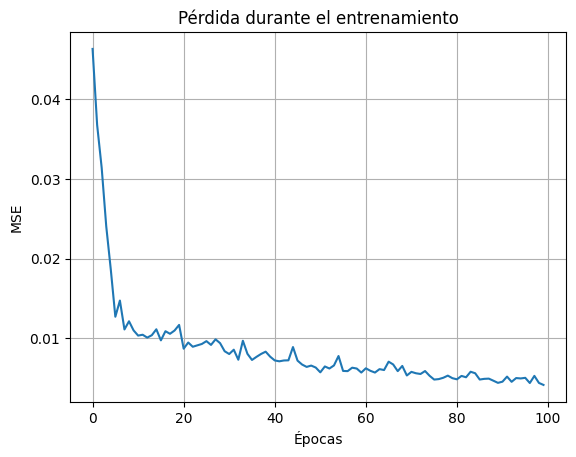

In [445]:
plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


In [446]:
predicciones = {}

for materia_id in df['materia_codificada'].unique():
    materia_df = df[df['materia_codificada'] == materia_id].sort_values('semestre_numerico')
    valores = materia_df[features + [target]].values

    if len(valores) >= pasos:
        secuencia = valores[-pasos:, :-1].reshape(1, pasos, len(features))
        y_pred = model.predict(secuencia)[0][0]

    
        ultima_fila_real = materia_df[escalar].values[-1].copy()
        ultima_fila_real[-1] = y_pred
        
        cupo_estimado = max(0, scaler.inverse_transform([ultima_fila_real])[0][-1])

        nombre_materia = diccionario_materias.get(materia_id, f"ID {materia_id}")
        predicciones[nombre_materia] = round(cupo_estimado)


1/1 [==============================] - 0s 24ms/step


In [447]:
df_pred = pd.DataFrame(list(predicciones.items()), columns=["Materia", "Cupos_Estimados"])
df_pred.to_excel("predicciones_cupos_proximo_semestre.xlsx", index=False)
print("✅ Archivo guardado: predicciones_cupos_proximo_semestre.xlsx")


✅ Archivo guardado: predicciones_cupos_proximo_semestre.xlsx


In [448]:
comparation()

                                                                                  Materia  Cupos_Usados  Cupos_Estimados  Error_Absoluto  Desviacion_%
                             SEMINARIO DE SOLUCION DE PROBLEMAS DE ESTRUCTURAS DE DATOS I             9               61              52    577.777778
                            SEMINARIO DE SOLUCION DE PROBLEMAS DE ESTRUCTURAS DE DATOS II            14               80              66    471.428571
                                                                           BASES DE DATOS            27               63              36    133.333333
                                                                               ALGORITMIA            26               57              31    119.230769
                                     SEMINARIO DE SOLUCION DE PROBLEMAS DE BASES DE DATOS            53              116              63    118.867925
                                                                               HIPERMEDIA     